# Spectrogram Segmentation

In this example, we use [PyTorch](https://pytorch.org/) and [Lightning](https://lightning.ai/docs/pytorch/stable/) to train a deep learning model to identify and differentiate between 5G NR and 4G LTE signals within wideband spectrograms.

## Outline

**[Background](#Background):** Delve into the problem background and learn more about the machine learning frameworks, tools, and datasets used in this example.

**[Set-up](#Set-Up):** Install the libraries necessary to run the code in this notebook.

**[Data Preprocessing](#Data-Preprocessing):** Load and analyze the Spectrum Sensing dataset.

**[Model Training](#Model-Training):** Configure and train a Deeplabv3 model with a MobileNetV3 backbone.

**[Model Validation](#Model-Validation):** Assess the performance of the model using a suite of common machine learning metrics.

**[Challenge Data](#Challenge-Data):** Challenge the model on combined frames containing both LTE and NR signal.

**[Conclusions & Next Steps](#Conclusions-&-Next-Steps):** Interpret the results, summarize key learnings, and identify steps for expanding upon this example.

## Background

5G NR (New Radio) and 4G LTE (Long-Term Evolution) are both cellular network technologies, but they represent 
different generations of mobile network standards. The ability to identify and distinguish between the two holds significant 
applications in [spectrum sensing](https://iopscience.iop.org/article/10.1088/1742-6596/2261/1/012016) and serves as a foundational example showcasing the near-term feasibility of 
[intelligent radio](https://www.qoherent.ai/intelligentradio/) technology.

A spectrogram, which depicts the frequency spectrum of a signal over time, is essentially just an image. Therefore, we can
apply state-of-the-art [semantic segmentation](https://www.ibm.com/topics/semantic-segmentation) techniques from 
the field of computer vision to the problem of spectrogram analysis. Our task is to assign one of the 
following labels to each pixel in the spectrogram: 'LTE', 'NR', or 'Noise'. ('Noise' refers to the absence of signal, representing 
a vacant or empty spectrum, also known as whitespace.)

The machine learning model utilized in this example is a DeepLabV3 model with a MobileNetV3 large backbone. The DeepLabv3 framework was originally introduced by Chen _et al._ in their 2017 paper titled '[Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587) and the MobileNetV3 backbone was developed by Howard _et al._ and is further discussed in their 2019 paper titled '[Searching for MobileNetV3](https://arxiv.org/abs/1905.02244)'. For an accessible introduction to the DeepLabV3 framework, please check out Isaac Berrios' article: [DeepLabv3: Building Blocks for Robust Segmentation Models](https://medium.com/@itberrios6/deeplabv3-c0c8c93d25a4).

The dataset used in this example is the Spectrum Sensing dataset, provided by MathWorks. This dataset contains 900 LTE frames, 900 NR frames, and 900 combined frames with both LTE and NR signal. In this example, we train exclusively on the individual LTE and NR examples, excluding the combined frames from the training process.

# Set-Up

In this section, we will install the dependencies required to run the code in this notebook. These dependencies include libraries and packages for tasks such as data manipulation, visualization, and machine learning.

In [1]:
%matplotlib inline

In [2]:
# !pip install torch_pruning

In [2]:
import glob
import os
import statistics
from typing import Any, Optional

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from matplotlib.colors import ListedColormap
from osgeo import gdal
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tabulate import tabulate
from torch import Tensor, nn
from torch.utils.data import DataLoader
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassConfusionMatrix,
    MulticlassF1Score,
    MulticlassJaccardIndex,
    MulticlassPrecision,
    MulticlassRecall,
)
from torchvision.datasets import VisionDataset
from torchvision.models.segmentation import (  
    deeplabv3_mobilenet_v3_large,
    deeplabv3_resnet50,
    deeplabv3_resnet101,
)
from torchvision.transforms.v2 import (
    Compose,
    Normalize,
    PILToTensor,
    ToDtype,
    ToPILImage,
)

import torch_pruning as tp
import copy
import math
from torch.nn.functional import softmax, log_softmax, kl_div
import random
import time

In [3]:
title_font_size, label_font_size = 14, 12

In [4]:
# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)                
torch.cuda.manual_seed(seed)          
random.seed(seed)                     
np.random.seed(seed)               

# Data Preprocessing

In semantic segmentation, the input data typically consists of images (in this case, spectrograms), while the output data consists of pixel-wise labels (masks) where each pixel is assigned a category label (in this case, either 'LTE', 'NR', or 'Noise'). 

We will use [supervised learning](https://www.ibm.com/topics/supervised-learning) techniques to train our model. These techniques require both input spectrograms and the corresponding target masks for training. For each frame in the dataset, we have two separate files:

- A `.png` file containing the spectrogram image to use as input to the model.

- A `.hdf` ([HDF4](https://www.hdfgroup.org/solutions/hdf4/)) file containing the target mask to use for training.

The Spectrum Sensing dataset also includes `.mat` files containing metadata such as the signal sample rate. However, none of this metadata is necessary for this example, so we can safely ignore these files.

Because spectrogram segmentation is a computer vision task, let's extend the [VisionDataset](https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html) class.

In [5]:
class SpectrumSensing(VisionDataset):

    def __init__(self, root: str, transform: Optional[callable] = None, target_transform: Optional[callable] = None):
        """Initialize the dataset, specifying the root directory where the dataset files are located."""
        super().__init__(root)

        self.root = root
        self.transform, self.target_transform = transform, target_transform

        # Parse the root directory and extract the basenames of individual LTE and NR frames.
        files = glob.glob(os.path.join(root, "*.png"))
        self.frames = [os.path.basename(frame).split(".")[0] for frame in files]

    def __len__(self) -> int:
        return len(self.frames)

    def __getitem__(self, idx: int) -> tuple[Image, Image]:
        """Return the image-mask pair at idx."""
        basename = self.frames[idx]

        image_file = os.path.join(self.root, f"{basename}.png")
        target_file = os.path.join(self.root, f"{basename}.hdf")

        image = Image.open(image_file)
        if self.transform is not None:
            image = self.transform(image)

        mask_data = gdal.Open(target_file)
        mask_band = mask_data.GetRasterBand(1)
        mask = (Image.fromarray(mask_band.ReadAsArray())).convert(mode="L")
        if self.target_transform is not None:
            mask = self.target_transform(mask)

        return image, mask

Notice our `SpectrumSensing` class accepts two functions/transforms: `transform`, which is applied to the spectrogram, 
and `target_transform`, which is applied to the mask.

Both the spectrograms and masks are 256 x 256 pixel images. However, the spectrograms are three channeled, while the masks are single-channeled. This is because the spectrograms are full RGB images, whereas the masks are ternary-valued images, where each pixel takes one of three discrete values:
- `0`: Representing noise.
- `127`: Representing NR signal.
- `255`: Representing LTE signal.

To prepare our spectrograms for training, we will convert them from PIL Images to Tensor objects. As required by our model, the images have to be loaded into the range `[0, 1]` and then normalized using a mean of `[0.485, 0.456, 0.406]` and a standard deviation of `[0.229, 0.224, 0.225]`. To prepare our masks for training, we will convert them to Tensor objects, remove the extraneous channel dimension, and update the pixel values such that `0` represents noise, `1` represents NR signal, and `2` represents LTE signal.

In [6]:
project_root = os.getcwd()
data_root = os.path.join(project_root, "SpectrumSensingDataset", "TrainingData")

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


class Squeeze(torch.nn.Module):
    def forward(self, target: Tensor):
        return torch.squeeze(target)


class DivideBy127(torch.nn.Module):
    # Mapping 0 -> 0, 127 -> 1, and 255 -> 2.
    def forward(self, target: Tensor):
        return torch.div(target, 127, rounding_mode="floor")


transform = Compose(
    [
        PILToTensor(),
        ToDtype(torch.float, scale=True),
        Normalize(mean=mean, std=std),
    ]
)

target_transform = Compose([PILToTensor(), Squeeze(), DivideBy127(), ToDtype(torch.long)])

Perfect. Now let's initialize the dataset, and take a closer look at a random training example and the corresponding mask. Due to our transforms, we expect that the image-mask pair will be returned as Tensor objects.

In [7]:
dataset = SpectrumSensing(root=data_root, transform=transform, target_transform=target_transform)

In [8]:
random_index = np.random.randint(len(dataset))
training_example, corresponding_mask = dataset[random_index]

print(f"The full dataset has {len(dataset)} examples. Loading example at index {random_index}.")
print(f"Spectrogram: {type(training_example)}, {training_example.dtype}, {training_example.size()}")
print(f"Mask: {type(corresponding_mask)}, {corresponding_mask.dtype}, {corresponding_mask.size()}")

The full dataset has 1800 examples. Loading example at index 1126.
Spectrogram: <class 'torch.Tensor'>, torch.float32, torch.Size([3, 256, 256])
Mask: <class 'torch.Tensor'>, torch.int64, torch.Size([256, 256])


The dataset should contain 1,800 samples: 900 NR frames and 900 LTE frames. 

To gain further insight, let's write some transforms to undo the previous normalization and prepare this image-mask pair for viewing. And, let's build a custom colormap for the masks, with noise as cyan, NR signal as blue, and LTE signal as purple.

In [9]:
inv_transform = Compose(
    [
        Normalize(mean=[0.0, 0.0, 0.0], std=[1 / x for x in std]),
        Normalize(mean=[-x for x in mean], std=[1.0, 1.0, 1.0]),
        ToPILImage(),
    ]
)

inv_target_transform = Compose([ToDtype(dtype=torch.uint8), ToPILImage()])

training_example = inv_transform(training_example)
corresponding_mask = inv_target_transform(corresponding_mask)

values, labels, colors = [0, 1, 2], ["Noise", "NR", "LTE"], ["cyan", "blue", "purple"]
mask_cmap = ListedColormap(colors)

print(f"Spectrogram: {training_example}")
print(f"Mask: {corresponding_mask}")

Spectrogram: <PIL.Image.Image image mode=RGB size=256x256 at 0x7D0E0205C510>
Mask: <PIL.Image.Image image mode=L size=256x256 at 0x7D0E01860CD0>


[Text(1, 0.33, 'Noise'), Text(1, 1.0, 'NR'), Text(1, 1.67, 'LTE')]

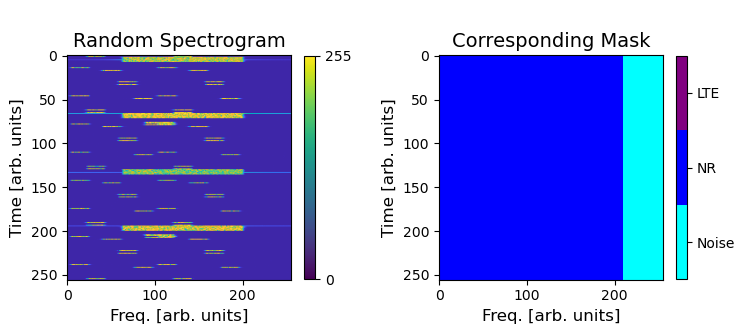

In [10]:
fig, (ax1, ax2) = plt.subplots(figsize=[8, 3.5], nrows=1, ncols=2)
plt.subplots_adjust(wspace=0.5)
ax1.set_title("\nRandom Spectrogram", fontsize=title_font_size)
ax2.set_title("Corresponding Mask", fontsize=title_font_size)
ax1.set_ylabel("Time [arb. units]", fontsize=label_font_size)
ax2.set_ylabel("Time [arb. units]", fontsize=label_font_size)
ax1.set_xlabel("Freq. [arb. units]", fontsize=label_font_size)
ax2.set_xlabel("Freq. [arb. units]", fontsize=label_font_size)

spect = ax1.imshow(training_example, vmin=0, vmax=255)
fig.colorbar(spect, ax=ax1, fraction=0.045, ticks=[0, 255])

mask = ax2.imshow(corresponding_mask, cmap=mask_cmap, vmin=0, vmax=2)
mask_cbar = fig.colorbar(mask, ax=ax2, cmap=mask_cmap, fraction=0.045, ticks=[0.33, 1, 1.67])
mask_cbar.ax.set_yticklabels(labels)

**Note:** You can view different examples from the dataset by rerunning the previous few code cells.

Let's analyze the relative frequencies of the different class labels. This step is critical for identifying imbalance in our dataset. Please note that the following code block might take a few seconds to run.

Text(0, 0.5, 'Counts (Normalized)')

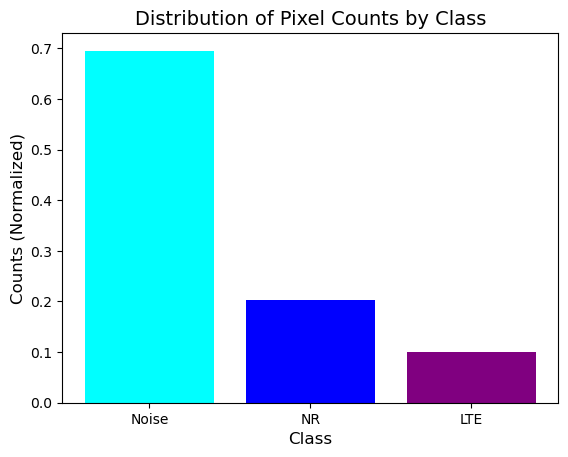

In [11]:
class_counts = {label: 0 for label in labels}

for _, mask in dataset:
    arr = np.asarray(mask)
    for i, label in enumerate(labels):
        class_counts[label] += np.sum(arr == values[i])

normalized_counts = np.array(list(class_counts.values())) / sum(list(class_counts.values()))

plt.bar(class_counts.keys(), normalized_counts, tick_label=labels, color=colors)
plt.title("Distribution of Pixel Counts by Class", fontsize=title_font_size)
plt.xlabel("Class", fontsize=label_font_size)
plt.ylabel("Counts (Normalized)", fontsize=label_font_size)

It looks like our dataset is mostly noise! A classification dataset like this—with skewed class proportions—is called imbalanced.

An imbalanced dataset can result in biased and poorly performing models. Models trained on imbalanced data tends to focus more on the majority classes and may not learn enough about the minority classes. To ensure the development of a fair, accurate, and robust model, we will need to address this class imbalance. 

But first, let's split the dataset into separate training and validation sets. The training dataset is the portion of the dataset that will be used to train the model, while the validation dataset will be held in reserve and used to evaluate the performance of the trained model. Let's start with a simple 80/20 split, where 80% of the dataset is used for training and 20% for validation.

In [12]:
train_split = 0.80
n_train_examples = int(len(dataset) * train_split)
n_val_examples = len(dataset) - n_train_examples

train_set, val_set = torch.utils.data.random_split(
    dataset=dataset, lengths=[n_train_examples, n_val_examples], generator=torch.Generator().manual_seed(42)
)

print(f"The training split contains {len(train_set)} examples.")
print(f"The validation split contains {len(val_set)} examples.")

The training split contains 1440 examples.
The validation split contains 360 examples.


In machine learning, data loaders facilitate easy access to samples, efficiently load and batch data, and offer numerous other features to streamline data preprocessing, management, and integration within the training loop. Let's create data loaders for both the training and validation datasets.

In PyTorch, the `DataLoader` class allows us to pass a `batch_size` argument, which controls the number of samples used in each pass through the network. Using a small number of training examples each pass is called mini-batching, and can improve efficiency, stabilize training dynamics, and enable scalable training on large datasets. Choosing an appropriate mini-batch size depends on several factors, including the available memory on your hardware, training efficiency constraints, and generalization requirements. However, as with everything in machine learning, we ultimately rely on empirical testing to determine the optimal configuration that maximizes model performance for each specific task and dataset. In this example, we'll use mini-batches containing 4 samples each, which will easily fit on any CPU/GPU without issue and provide reasonable generalization performance.

In [13]:
batch_size = 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

spects, masks = next(iter(train_loader))

print(f"Batch of spectrograms: {type(spects)}, {spects.dtype}, {spects.size()}")
print(f"Batch of masks: {type(masks)}, {masks.dtype}, {masks.size()}")

Batch of spectrograms: <class 'torch.Tensor'>, torch.float32, torch.Size([3, 3, 256, 256])
Batch of masks: <class 'torch.Tensor'>, torch.int64, torch.Size([3, 256, 256])


Let's examine a batch of spectrograms along with their corresponding masks. Please note that the following plotting code is optimized for small batch sizes and may not render as nicely with larger batch sizes.

In [14]:
def plot_spects(spects: list[Image.Image]) -> None:
    fig, axes = plt.subplots(figsize=[batch_size * 2, 3], nrows=1, ncols=batch_size, sharey=True)
    fig.text(0.5, 0.75, "Spectrograms", fontsize=title_font_size, ha="center")
    axes[0].set_ylabel("Time [arb. units]", fontsize=label_font_size)
    fig.text(0.5, 0.12, "Freq. [arb. units]", fontsize=label_font_size, ha="center")

    for i, ax in enumerate(axes):
        im = ax.imshow(spects[i], vmin=0, vmax=255)

    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes(rect=[0.93, 0.24, 0.02, 0.5])
    fig.colorbar(im, cax=cbar_ax, ticks=[0, 255])


def plot_masks(masks: list[Image.Image], prediction: bool = False, is_pruned: bool = False, is_teacher: bool = False) -> None:
    fig, axes = plt.subplots(figsize=[batch_size * 2, 3], nrows=1, ncols=batch_size, sharey=True)
    if prediction:
        if is_pruned:
            fig.text(0.5, 0.75, "Pruned Model Predictions", fontsize=title_font_size, ha="center")
        elif is_teacher:
            fig.text(0.5, 0.75, "Teacher Model Predictions", fontsize=title_font_size, ha="center")
        else:
            fig.text(0.5, 0.75, "Model Predictions", fontsize=title_font_size, ha="center")
    else:
        fig.text(0.5, 0.75, "Masks", fontsize=title_font_size, ha="center")
    axes[0].set_ylabel("Time [arb. units]", fontsize=label_font_size)
    fig.text(0.5, 0.12, "Freq. [arb. units]", fontsize=label_font_size, ha="center")

    for i, ax in enumerate(axes):
        im = ax.imshow(masks[i], vmin=0, vmax=2, cmap=mask_cmap)

    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes(rect=[0.93, 0.24, 0.02, 0.5])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0.33, 1, 1.66])
    cbar.ax.set_yticklabels(labels)

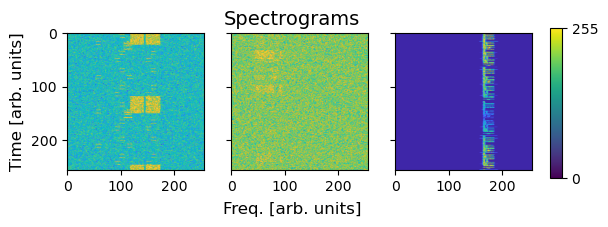

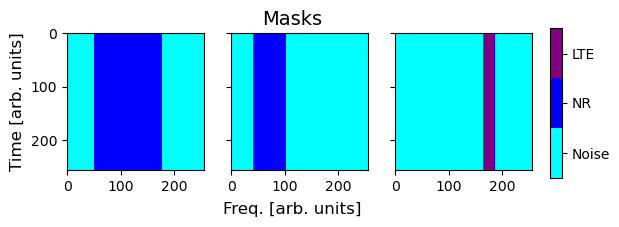

In [15]:
plot_spects(spects=[inv_transform(i) for i in spects])
plot_masks(masks=[inv_target_transform(i) for i in masks], is_pruned=False)

**Note:** You can view different batches from the dataset by rerunning the previous few code cells.

In [16]:
n_classes = 3  # We are dealing with three classes: Noise, NR, and LTE.
median_count = statistics.median(list(class_counts.values()))
weight = [median_count / class_counts[k] for k in class_counts.keys()]
norm = math.sqrt(sum(x**2 for x in weight))
normalized_list = [x / norm for x in weight]
loss_function = nn.CrossEntropyLoss(weight=torch.tensor(weight, dtype=torch.float))

print("Class weights: ", {k: round(weight[i], 2) for i, k in enumerate(class_counts.keys())})

Class weights:  {'Noise': 0.29, 'NR': 1.0, 'LTE': 2.02}


In [58]:
general_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
trained_model = torch.load('./trained_model/best_model.pth')

blocks = []

# Iterate through the top-level children of the model
for name, module in trained_model.named_children():
    if name == 'classifier':
        for idx, (backbone_name, backbone_module) in enumerate(module.named_children()):
            blocks.append(backbone_module)

    elif name == 'backbone':
        # Iterate over the top-level children of the backbone
        for idx, (backbone_name, backbone_module) in enumerate(module.named_children()):
            blocks.append(backbone_module)

In [62]:
def prune_model(trained_model, prune_method, pruning_ratios, train_loader, device):
    
    # Make a copy of the trained model
    model = copy.deepcopy(trained_model).to(device)  

    blocks = []
    model_blocks = []
    ignored_blocks = []

    # Iterate through the top-level children of the model
    for name, module in model.named_children():
        if name == 'classifier':
            for idx, (backbone_name, backbone_module) in enumerate(module.named_children()):
                blocks.append(backbone_module)

        elif name == 'backbone':
            # Iterate over the top-level children of the backbone
            for idx, (backbone_name, backbone_module) in enumerate(module.named_children()):
                blocks.append(backbone_module)

    model_blocks.extend(blocks[1:-4])
    ignored_blocks.extend(blocks[:1])
    ignored_blocks.extend(blocks[-4:])

    # Prepare pruning information for each block
    pruning_info = {
        i: {"block": model_blocks[i], "pruning_ratio": ratio}
        for i, ratio in enumerate(pruning_ratios)
    }

    if prune_method == 'channel_pruning_Taylor_importance':
        # Initialize TaylorImportance for pruning
        imp = tp.importance.TaylorImportance() 

        # Prepare a batch from the train loader for pruning and backward pass
        spects, masks = next(iter(train_loader))
        spects, masks = spects.to(device), masks.to(device)

        # Perform forward and backward passes to calculate importance scores
        if isinstance(imp, tp.importance.TaylorImportance):
            if hasattr(loss_function, 'weight') and loss_function.weight is not None:
                loss_function.weight = loss_function.weight.to(device)
            preds = model(spects)["out"]
            loss = loss_function(preds, masks)
            loss.backward()

        # Define layers to be ignored during pruning
        ignored_layers = ignored_blocks

        # Example input for MACs and Params calculation
        # example_inputs = torch.randn(1, 8, 4096).to('cpu')
        original_macs, original_nparams = tp.utils.count_ops_and_params(model, spects)

        # Iterate through each block and apply pruning
        for i, info in pruning_info.items():
            block_to_prune = info["block"]
            pruning_ratio = info["pruning_ratio"]

            # Ignore all blocks except the current block to prune
            ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]
            combined_ignored_layers = ignored_layers + ignored_layers_block

            count = 0  # Counter for consecutive iterations without parameter reduction
            # print(f"Pruning block {i+1}/{len(pruning_info)}")
            if pruning_ratio == 0:
                continue
            
            # Pruning loop: Continue pruning until no parameters are further reduced
            while True:

                # print(f"Pruning ratio: {pruning_ratio}")
                
                # Apply pruning for the current block
                pruner_group = tp.pruner.MagnitudePruner(
                    model,
                    example_inputs=spects,
                    importance=imp,
                    pruning_ratio=pruning_ratio,
                    ignored_layers=combined_ignored_layers
                )
                pruner_group.step()

                # Recalculate MACs and parameters after pruning
                macs, nparams = tp.utils.count_ops_and_params(model, spects)
                # print(f"MACs: {macs / 1e9:.2f} G, #Params: {nparams / 1e3:.2f} K")
                # print(f"Parameter reduction: {original_nparams - nparams}")
                
                # Check if no parameters were reduced, then break the loop
                if original_nparams - nparams == 0:
                    count += 1
                    if count == 1:
                        pruning_ratio = 0.5  # Adjust pruning ratio
                        # print(f"Consecutive iterations without parameter reduction: {count}")
                        # print(f"Adjusting pruning ratio to {pruning_ratio}")
                    else:
                        break

                # Update the pruning ratio for iterative pruning
                original_nparams = nparams
                # pruning_ratio = 0.5  # Adjust pruning ratio for the next iteration

        # Free up memory
        del spects, preds
        torch.cuda.empty_cache()

    return model, macs, nparams

In [71]:
# Function to perform perplexity
def perplexity_analysis_with_contributions(original_model, data_loader, metric, device, criterion=None):

    blocks = []
    model_blocks = []

    # Iterate through the top-level children of the model
    for name, module in original_model.named_children():
        if name == 'classifier':
            for idx, (backbone_name, backbone_module) in enumerate(module.named_children()):
                blocks.append(backbone_module)

        elif name == 'backbone':
            # Iterate over the top-level children of the backbone
            for idx, (backbone_name, backbone_module) in enumerate(module.named_children()):
                blocks.append(backbone_module)

    model_blocks.extend(blocks[1:-4])
    blocks_number = len(model_blocks)

    total_block_performance = [0.0 for _ in range(blocks_number)] #TODO add the number dynamically
    params_reduction = []  # Store the parameter reduction for each block
    macs_reduction = []

    # Step 1: Compute the baseline performance (without block replacement)
    original_model.to(device)
    print(f"Computing baseline {metric} without block replacement...")
    baseline_performance = compute_baseline_performance(original_model, data_loader, device)
    print(f"Baseline {metric}: {baseline_performance}")

    
    example_inputs = torch.randn(1, 3, 256, 256).to(device)  # Generate example input for calculating MACs and parameters
    original_macs, original_nparams = tp.utils.count_ops_and_params(original_model, example_inputs)
    

    # Iterate through each block for replacement
    for block_idx in range(blocks_number):

        # output_channels = get_first_layer_output_channels(original_model)

        print(f"Replacing block {block_idx}")
        pruning_ratios = pruning_ratios = (np.eye(blocks_number) * 0.8)[block_idx]
        
        pruned_model, macs, nparams = prune_model(original_model,'channel_pruning_Taylor_importance', pruning_ratios, data_loader, device)

        print(f"Macs reduction is: {((original_macs - macs) / original_macs * 100):.2f}%", f"Parameters reduction is: {((original_nparams - nparams)/original_nparams*100):.2f}%")

        # Record the parameter reduction
        params_reduction.append((original_nparams - nparams)/original_nparams * 100)
        macs_reduction.append((original_macs - macs) / original_macs * 100)
        
        pruned_model.to(device)

        # Run validation and compute performance
        block_performance = compute_baseline_performance(pruned_model, data_loader, device)

        total_block_performance[block_idx] = block_performance
        print(f'The {metric} after pruning this block is: ', total_block_performance[block_idx])

    # Step 2: Calculate the final averaged performance and contribution for each block across iterations
    total_degradation_in_performance = 0.0
    block_degradation = []
    total_params_reduction = 0.0
    total_macs_reduction = 0.0
    
    for block_idx in range(blocks_number):
        final_average_performance = total_block_performance[block_idx]
        degradation_in_performance = np.abs(final_average_performance - baseline_performance)
        print(f"degradation in {metric} is: ", degradation_in_performance)
        block_degradation.append(degradation_in_performance)
        total_degradation_in_performance += degradation_in_performance  # Accumulate total degradation in performance
        total_params_reduction += params_reduction[block_idx]  # Accumulate total parameter reduction
        total_macs_reduction += macs_reduction[block_idx]  # Accumulate total macs reduction
    
    # Step 3: Calculate the relative contribution of each block to the total degradation in performance and params saved
    relative_contributions = []
    weighted_importance_scores = []
    print(f"\nRelative contribution of each block to total {metric} degradation and parameter reduction:")

    for block_idx in range(blocks_number):
        # Calculate relative contribution to the performance degradation
        relative_contribution_performance = ((block_degradation[block_idx] / total_degradation_in_performance))* 100
        
        # Adjust parameter contribution to reflect reduced importance for larger reductions
        relative_contribution_params = 100 - params_reduction[block_idx] #(1 - (params_reduction[block_idx] / total_params_reduction)) * 100
        relative_contribution_macs = 100 - macs_reduction[block_idx] #(1 - (macs_reduction[block_idx] / total_macs_reduction)) * 100

        # Combine these two using a weighted importance score (example: 70% weight to performance, 30% to parameter savings)
        weight_performance = 0.5
        weight_params = 0.3
        weight_macs = 0.2
        weighted_importance = (weight_performance * relative_contribution_performance) + (weight_params * relative_contribution_params) + (weight_macs * relative_contribution_macs)
        
        print(f'Block {block_idx} contributes {relative_contribution_performance:.2f}% to the total degradation in {metric} and reduces {params_reduction[block_idx]:.2f}% of parameters.')
        print(f'Weighted importance score for Block {block_idx}: {weighted_importance:.2f}')
        
        relative_contributions.append(relative_contribution_performance)
        weighted_importance_scores.append(weighted_importance)

    # Return both the relative performance contributions and weighted importance scores
    return weighted_importance_scores

# Helper function to compute the baseline performance (without replacing any block)
def compute_baseline_performance(model, data_loader, device):

    metrics = [
        MulticlassAccuracy(num_classes=n_classes, average=None),
        MulticlassRecall(num_classes=n_classes, average=None),
        MulticlassPrecision(num_classes=n_classes, average=None),
        MulticlassF1Score(num_classes=n_classes, average=None),
        # The IoU is commonly referred to as Jaccard's Index
        MulticlassJaccardIndex(num_classes=n_classes, average=None),
    ]
    metrics = [m.to(device) for m in metrics]

    with torch.inference_mode():
        for spect, mask in data_loader:
            spect, mask = spect.to(device), mask.to(device)
            pred = (model(spect)["out"]).argmax(dim=1)
            for m in metrics:
                m.update(pred, mask)

    metrics = [m.compute().cpu().numpy() for m in metrics]
    metrics = [np.append(m, statistics.mean(m)) for m in metrics]

    del spect, mask
    del model
    torch.cuda.empty_cache()

    return metrics[3][-1]

In [72]:
trained_model = torch.load('./trained_model/best_model.pth')
relative_contribution = perplexity_analysis_with_contributions(trained_model, val_loader, metric='accuracy', device=general_device)

Computing baseline accuracy without block replacement...
Baseline accuracy: 0.9323678016662598
Replacing block 0
Macs reduction is: 0.00% Parameters reduction is: 0.00%
The accuracy after pruning this block is:  0.9323678
Replacing block 1
Macs reduction is: 1.17% Parameters reduction is: 0.03%
The accuracy after pruning this block is:  0.64057505
Replacing block 2
Macs reduction is: 0.74% Parameters reduction is: 0.04%
The accuracy after pruning this block is:  0.7672837
Replacing block 3
Macs reduction is: 0.52% Parameters reduction is: 0.09%
The accuracy after pruning this block is:  0.28267646
Replacing block 4
Macs reduction is: 0.55% Parameters reduction is: 0.19%
The accuracy after pruning this block is:  0.8814267
Replacing block 5
Macs reduction is: 0.55% Parameters reduction is: 0.19%
The accuracy after pruning this block is:  0.86749303
Replacing block 6
Macs reduction is: 0.64% Parameters reduction is: 0.29%
The accuracy after pruning this block is:  0.27247483
Replacing bl

In [73]:
relative_contribution

[50.0,
 52.86736938477918,
 51.599676715307034,
 56.79274242400224,
 50.37600940192581,
 50.5245129193618,
 56.81854964522629,
 50.46869578843791,
 51.04258395930866,
 50.04845694029277,
 56.25249884109339,
 49.02853423300394,
 54.61461659835188,
 47.30864735548195,
 47.13673513320185,
 22.697753449165873,
 19.140327717091665]

In [42]:
def calculate_pruning_ratios_intense(contributions, max_pruning_ratio=0.9, k=5):
    """
    Calculate pruning ratios based on intense nonlinear scaling (exponential decay) of the relative contributions.

    Parameters:
    - contributions (list): List of relative contributions (in percentages) of each block to total loss increase.
    - max_pruning_ratio (float): Maximum pruning ratio to be assigned to the least important layer. Default is 0.9.
    - k (int): Factor controlling the intensity of the scaling (larger k makes the ratio more intense).

    Returns:
    - pruning_ratios (list): List of pruning ratios for each block.
    """
    # Normalize the contributions to get values between 0 and 1
    total_contribution = sum(contributions)
    normalized_contributions = [contribution / total_contribution for contribution in contributions]

    # Apply exponential decay to magnify the effect for less important blocks
    pruning_factors = [np.exp(-k * nc) for nc in normalized_contributions]

    # Normalize the pruning factors so they stay within the max pruning ratio
    max_factor = max(pruning_factors)
    normalized_factors = [pf / max_factor for pf in pruning_factors]

    # Scale by the maximum pruning ratio
    pruning_ratios = [max_pruning_ratio * nf for nf in normalized_factors]

    pruning_ratios = [round(num, 2) for num in pruning_ratios]

    return pruning_ratios

In [74]:
max_pruning_ratio = 0.99 # Maximum pruning ratio (99%) 
k = 5 # Controls the intensity of the scaling

pruning_ratios = calculate_pruning_ratios_intense(relative_contribution, max_pruning_ratio, k)

# Print the pruning ratios for each block
for i, ratio in enumerate(pruning_ratios):
    print(f"Block {i} Pruning Ratio: {ratio:.4f}")

Block 0 Pruning Ratio: 0.8200
Block 1 Pruning Ratio: 0.8100
Block 2 Pruning Ratio: 0.8100
Block 3 Pruning Ratio: 0.7900
Block 4 Pruning Ratio: 0.8200
Block 5 Pruning Ratio: 0.8200
Block 6 Pruning Ratio: 0.7900
Block 7 Pruning Ratio: 0.8200
Block 8 Pruning Ratio: 0.8100
Block 9 Pruning Ratio: 0.8200
Block 10 Pruning Ratio: 0.7900
Block 11 Pruning Ratio: 0.8200
Block 12 Pruning Ratio: 0.8000
Block 13 Pruning Ratio: 0.8300
Block 14 Pruning Ratio: 0.8300
Block 15 Pruning Ratio: 0.9700
Block 16 Pruning Ratio: 0.9900


In [32]:
n_classes = 3  # We are dealing with three classes: Noise, NR, and LTE.
median_count = statistics.median(list(class_counts.values()))
weight = [median_count / class_counts[k] for k in class_counts.keys()]
loss_function = nn.CrossEntropyLoss(weight=torch.tensor(weight, dtype=torch.float))

print("Class weights: ", {k: round(weight[i], 2) for i, k in enumerate(class_counts.keys())})

Class weights:  {'Noise': 0.29, 'NR': 1.0, 'LTE': 2.02}


In [33]:
def prune_model(trained_model, prune_method, pruning_ratios, train_loader, seed=42):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Make a copy of the trained model
    model = copy.deepcopy(trained_model).to('cpu')  # Assuming general_device is defined elsewhere

    blocks = []

    # Iterate through the top-level children of the model
    for name, module in model.named_children():
        if name == 'classifier':
            for idx, (backbone_name, backbone_module) in enumerate(module.named_children()):
                blocks.append(backbone_module)

        elif name == 'backbone':
            # Iterate over the top-level children of the backbone
            for idx, (backbone_name, backbone_module) in enumerate(module.named_children()):
                blocks.append(backbone_module)

    model_blocks = blocks[2:-4]
    ignored_blocks = blocks[0:2] + blocks[-4:]

    # Prepare pruning information for each block
    pruning_info = {
        i: {"block": model_blocks[i], "pruning_ratio": ratio}
        for i, ratio in enumerate(pruning_ratios)
    }

    if prune_method == 'channel_pruning_Taylor_importance':
        # Initialize TaylorImportance for pruning
        imp = tp.importance.TaylorImportance() 

        # Prepare a batch from the train loader for pruning and backward pass
        spects, masks = next(iter(train_loader))
        spects, masks = spects.to('cpu'), masks.to('cpu')

        # Perform forward and backward passes to calculate importance scores
        if isinstance(imp, tp.importance.TaylorImportance):
            if hasattr(loss_function, 'weight') and loss_function.weight is not None:
                loss_function.weight = loss_function.weight.to('cpu')
            preds = model(spects)["out"]
            loss = loss_function(preds, masks)
            loss.backward()

        # Define layers to be ignored during pruning
        ignored_layers = ignored_blocks

        # Example input for MACs and Params calculation
        # example_inputs = torch.randn(1, 8, 4096).to('cpu')
        original_macs, original_nparams = tp.utils.count_ops_and_params(model, spects)

        # Iterate through each block and apply pruning
        for i, info in pruning_info.items():
            block_to_prune = info["block"]
            pruning_ratio = info["pruning_ratio"]

            # Ignore all blocks except the current block to prune
            ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]
            combined_ignored_layers = ignored_layers + ignored_layers_block

            print(f"Pruning block {i} with initial ratio: {pruning_ratio}")
            
            # Apply pruning for the current block
            pruner_group = tp.pruner.MagnitudePruner(
                model,
                example_inputs=spects,
                importance=imp,
                pruning_ratio=pruning_ratio,
                ignored_layers=combined_ignored_layers
            )
            pruner_group.step()

    # Recalculate MACs and parameters after pruning
    macs, nparams = tp.utils.count_ops_and_params(model, spects)
    print(f"MACs: {macs / 1e9:.2f} G, #Params: {nparams / 1e3:.2f} K")
    print(f"Parameter reduction: {original_nparams - nparams}")
            

    # Free up memory
    # del x, y
    torch.cuda.empty_cache()

    return model, macs, nparams

In [34]:
pruned_model, macs, nparams = prune_model(trained_model,'channel_pruning_Taylor_importance', pruning_ratios, val_loader)

Pruning block 0 with initial ratio: 0.88
Pruning block 1 with initial ratio: 0.89
Pruning block 2 with initial ratio: 0.86
Pruning block 3 with initial ratio: 0.89
Pruning block 4 with initial ratio: 0.89
Pruning block 5 with initial ratio: 0.86
Pruning block 6 with initial ratio: 0.89
Pruning block 7 with initial ratio: 0.89
Pruning block 8 with initial ratio: 0.9
Pruning block 9 with initial ratio: 0.86
Pruning block 10 with initial ratio: 0.9
Pruning block 11 with initial ratio: 0.87
Pruning block 12 with initial ratio: 0.91
Pruning block 13 with initial ratio: 0.91
Pruning block 14 with initial ratio: 0.98
Pruning block 15 with initial ratio: 0.99
MACs: 0.06 G, #Params: 164.33 K
Parameter reduction: 10856522


In [35]:
class Self_SegmentationSGD(L.LightningModule):
    def __init__(
        self, 
        model: nn.Module,
        loss_function: nn.Module,
        teacher_model: nn.Module,
        n_classes: int,
        learning_rate: float,
        momentum: float,
        weight_decay: float,
        step_size: int,
        gamma: float,
        alpha: float,  # Trade-off factor for KD loss
        beta: float,   # Trade-off factor for hard loss 
        gamma_self: float,  # Trade-off factor for self-distillation loss
        temperature: float,  # Temperature for distillation
        class_weights: float,
        ema_decay: float  # Decay rate for EMA
    ):
        super().__init__()
        self.model = model
        self.loss_function = loss_function
        self.teacher_model = teacher_model
        self.n_classes = n_classes

        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.step_size = step_size
        self.gamma = gamma

        self.alpha = alpha
        self.beta = beta
        self.gamma_self = gamma_self
        self.temperature = temperature
        self.ema_decay = ema_decay

        self.class_weights = torch.tensor(class_weights, dtype=torch.float, device='cuda').view(1, 3, 1, 1)

        self.train_accuracy = MulticlassAccuracy(num_classes=self.n_classes)
        self.val_accuracy = MulticlassAccuracy(num_classes=self.n_classes)

        # Freeze the teacher model 
        self.teacher_model.eval()
        for param in self.teacher_model.parameters():
            param.requires_grad = False

        # Initialize EMA model
        self.ema_model = copy.deepcopy(self.model)
        self.ema_model.eval()  # EMA model is always in eval mode
        for param in self.ema_model.parameters():
            param.requires_grad = False

    def forward(self, x: Tensor) -> Tensor:
        """Defines a forward pass through the student model."""
        return self.model(x)            

    def update_ema_model(self):
        """Updates the EMA model's parameters using the current model's parameters."""
        for ema_param, model_param in zip(self.ema_model.parameters(), self.model.parameters()):
            ema_param.data = self.ema_decay * ema_param.data + (1.0 - self.ema_decay) * model_param.data

    def training_step(self, batch: Tensor, batch_idx: int) -> Tensor:
        """Defines a single training step with knowledge distillation and self-distillation."""
        image, target = batch

        # Student predictions
        student_preds = self(image)["out"]

        # Teacher predictions (soft targets)
        with torch.no_grad():
            teacher_preds = self.teacher_model(image)["out"]

        # Compute teacher soft targets
        teacher_soft_targets = softmax(teacher_preds / self.temperature, dim =1)
        student_soft_targets = log_softmax(student_preds / self.temperature, dim=1)

        # Distillation loss
        kl_per_class = kl_div(student_soft_targets, teacher_soft_targets, reduction="none")
        kl_weighted = kl_per_class * self.class_weights
        distillation_loss = kl_weighted.sum(dim=1).mean() * (self.temperature ** 2)

        # Hard target loss
        hard_loss = self.loss_function(student_preds, target)

        # Self-distillation loss (using EMA model as pseudo-labels)
        with torch.no_grad():
            ema_preds = self.ema_model(image)["out"]  # EMA model predictions
            ema_soft_targets = softmax(ema_preds / self.temperature, dim=1)

        student_self_targets = log_softmax(student_preds / self.temperature, dim=1)
        self_kl_per_class = kl_div(student_self_targets, ema_soft_targets, reduction="none")
        self_kl_weighted = self_kl_per_class * self.class_weights
        self_distillation_loss = self_kl_weighted.sum(dim=1).mean() * (self.temperature ** 2)

        # Combined loss
        loss = self.alpha * distillation_loss + self.beta * hard_loss + self.gamma_self * self_distillation_loss

        # Log metrics
        self.train_accuracy(student_preds, target)
        self.log(name="train_accuracy", value=self.train_accuracy, prog_bar=True)
        self.log(name="train_loss", value=loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log(name="distillation_loss", value=distillation_loss, on_epoch=True, on_step=True)
        self.log(name="hard_loss", value=hard_loss, on_epoch=True, on_step=True)
        self.log(name="self_distillation_loss", value=self_distillation_loss, on_epoch=True, on_step=True)

        # Update EMA model after the loss computation
        self.update_ema_model()

        return loss
    
    def validation_step(self, batch: Tensor, batch_idx: int) -> Tensor:
        """Defines a single validation step."""
        image, target = batch
        preds = self(image)["out"]
        loss = self.loss_function(preds, target)
        self.val_accuracy(preds, target)  prog_bar=True)
        return loss

    def configure_optimizers(self) -> dict[str, Any]:
        """Configure the optimizer and learning rate scheduler."""
        optimizer = torch.optim.SGD(
            self.parameters(), lr=self.learning_rate, momentum=self.momentum, weight_decay=self.weight_decay
        )
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=self.step_size, gamma=self.gamma)

        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

In [36]:
class CustomCheckpoint(L.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_validation_end(self, trainer, pl_module):
        # Access validation loss from the trainer's metrics
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = pl_module.model
            # Save the best model
            torch.save(self.best_model, 'KD_trained_model/best_model.pth')
            print(f"New best model saved with validation loss {val_loss:.4f}")


import lightning.pytorch

checkpoint_filename = f"KD_trained_model/final_original_model.ckpt"
checkpoint_callback = lightning.pytorch.callbacks.ModelCheckpoint(
        dirpath='.',
        filename=checkpoint_filename.replace(".ckpt", ""),
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )

# Create the custom callback
custom_checkpoint = CustomCheckpoint()

In [30]:
my_list = weight

norm = sum(x for x in my_list)

KD_weights = [x / norm for x in my_list]
print(KD_weights) 
print(weight) 

[0.08849170357454535, 0.30199664834882145, 0.6095116480766333]
[0.2930221380216543, 1.0, 2.0182728894812647]


In [31]:
loss_function = nn.CrossEntropyLoss(weight=torch.tensor(KD_weights, dtype=torch.float))

In [37]:
self_segmentation_module = Self_SegmentationSGD(
    model=pruned_model,
    loss_function=loss_function,
    teacher_model=trained_model,
    n_classes=n_classes,
    learning_rate=0.001,  # Represents the initial learning rate.
    momentum=0.9,
    weight_decay=1.0e-04,
    step_size=10,
    gamma=0.1,
    gamma_self=0,
    alpha=0,
    beta=1,
    temperature=2,
    class_weights=weight, #KD_weights, #[x**2 for x in weight] #weight
    ema_decay=0.999
)

In [38]:
n_epochs = 30
# n_epochs = 4  # Suggested for CPU training.

if torch.cuda.is_available():
    print("Training model on GPU.")
    trainer = L.Trainer(accelerator="gpu", devices=1, callbacks=[custom_checkpoint], max_epochs=n_epochs, logger=True)
    device = "cuda"
else:
    print("Training model on CPU.")
    trainer = L.Trainer(max_epochs=n_epochs, logger=True)
    device = "cpu"

trainer.fit(model=self_segmentation_module, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ict317-3/miniconda3/envs/spectrogram-segmentation/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more detai

Training model on GPU.


Sanity Checking: 0it [00:00, ?it/s]

/home/ict317-3/miniconda3/envs/spectrogram-segmentation/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ict317-3/miniconda3/envs/spectrogram-segmentation/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


New best model saved with validation loss 3.3669


/home/ict317-3/miniconda3/envs/spectrogram-segmentation/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/ict317-3/miniconda3/envs/spectrogram-segmentation/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: 0it [00:00, ?it/s]

New best model saved with validation loss 0.7945


Validation: 0it [00:00, ?it/s]

New best model saved with validation loss 0.6613


Validation: 0it [00:00, ?it/s]

New best model saved with validation loss 0.6395


Validation: 0it [00:00, ?it/s]

New best model saved with validation loss 0.5368


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

New best model saved with validation loss 0.4367


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/ict317-3/miniconda3/envs/spectrogram-segmentation/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Model Validation

Having trained our model, the next step is to evaluate its performance. To accomplish this, we'll use a suite of standard machine learning metrics. But first, let's take a look at a random batch of predictions.

Because the model returns the probabilities corresponding to the predictions of each class. We need to use `argmax()` to obtain the class with the highest prediction probability. The result is a singe-channel image for each example in the batch, which can be compared directly to the corresponding target mask.

In [39]:
teacher_model = torch.load('./trained_model/best_model.pth')

In [54]:
model = torch.load('./KD_trained_model/best_model.pth')

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

spects, masks = next(iter(train_loader))
spects = spects.to(device)

In [58]:
model.eval()
model.to(device)


with torch.inference_mode():
    preds = (model(spects)["out"]).argmax(1)

print("Predictions:", preds.size())

Predictions: torch.Size([3, 256, 256])


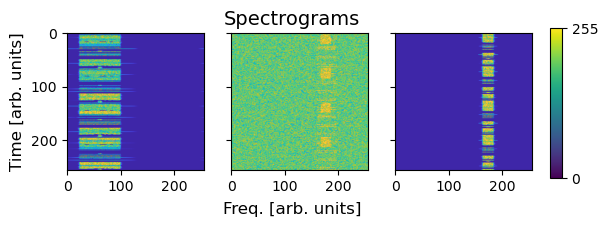

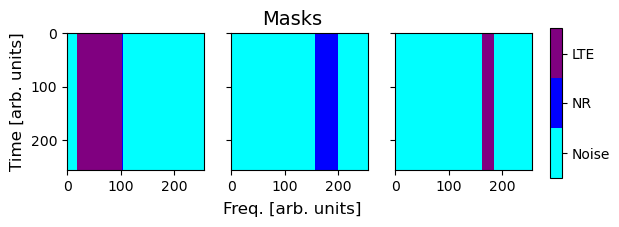

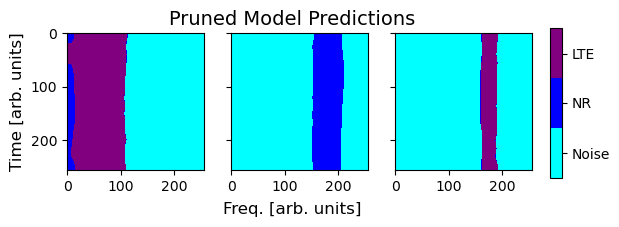

In [59]:
plot_spects(spects=[inv_transform(i.cpu()) for i in spects])
plot_masks(masks=[inv_target_transform(i) for i in masks])
plot_masks(masks=preds.cpu(), prediction=True, is_pruned=True)

Looks pretty good! But to get a more objective sense, let's turn to the metrics. Let's start with model accuracy, calculated as the ratio of correctly predicted pixels to the total number of pixels.

**Note:** You can view different predictions by rerunning the previous few code cells.

In [55]:
self_segmentation_module = Self_SegmentationSGD(
    model=model,
    loss_function=loss_function,
    teacher_model=teacher_model,
    n_classes=n_classes,
    learning_rate=0.001,  # Represents the initial learning rate.
    momentum=0.9,
    weight_decay=1.0e-04,
    step_size=10,
    gamma=0.1,
    gamma_self=1,
    alpha=1,
    beta=1,
    temperature=2,
    class_weights=weight, #[x**2 for x in weight] #weight
    ema_decay=0.999
)

In [56]:
trainer = L.Trainer(
    accelerator='gpu',  # Use GPU
    devices=1,          # Single GPU
    logger=True         # Logging enabled
)
scores = trainer.validate(model=self_segmentation_module, dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ict317-3/miniconda3/envs/spectrogram-segmentation/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.863723635673523     │
│         val_loss          │    0.43670642375946045    │
└───────────────────────────┴───────────────────────────┘

The accuracy can give us a quick sense of the model's overall performance. However, accuracy alone doesn't tell the whole story. In fact, because of the imbalance in our dataset, a reasonably high accuracy could be achieved by always predicting  noise. The simple accuracy provided above is an unweighted mean of the accuracies over each class.

To gain a better understanding of our model's ability to predict specific classes, let's take a look at the confusion matrix, which provides a more comprehensive overview of model capability. The diagonal elements represent the correct predictions and off-diagonal elements indicate prediction errors.

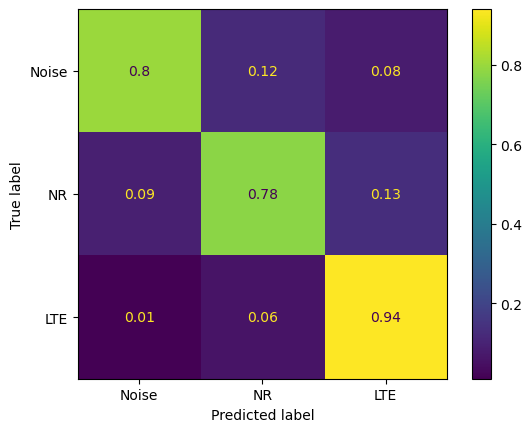

In [42]:
model.to(device)
confusion_matrix = MulticlassConfusionMatrix(num_classes=n_classes, normalize="true").to(device)

with torch.inference_mode():
    for spect, mask in val_loader:
        spect, mask = spect.to(device), mask.to(device)
        pred = (model(spect)["out"]).argmax(dim=1)
        confusion_matrix.update(pred, mask)

confusion_matrix = np.round(confusion_matrix.compute().cpu().numpy(), decimals=2)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels).plot()

Finally, let's generate a more comprehensive report, complete with the following metrics:

- **Recall:** The recall (sensitivity) measures the ability of the model to identify the relevant pixels. A higher recall indicates that the model is better at identifying signal.

- **Precision:** The precision assesses the accuracy of positive predictions. A higher precision indicates that when the model predicts signal, it is more likely to be correct.

- **F1 Score:** The F1 score combines both recall and precision into a single value, providing a more balanced measure of the model's performance. A higher F1 indicates a model with both good precision and recall (fewer false positives and false negatives overall).

- **Intersection over Union (IoU):** The IoU quantifies the overlap between the predicted bounding box or segmented region and the ground truth. A higher IoU value indicates a better alignment between the predicted and actual regions, reflecting a more accurate model.

In [69]:
def print_metrics_report(dataloader: DataLoader, model) -> None:
    """Compute accuracy, recall, precision, F1 score, and IoU (Intersection over Union),
    and print a report containing these metrics."""
    metrics = [
        MulticlassAccuracy(num_classes=n_classes, average=None),
        MulticlassRecall(num_classes=n_classes, average=None),
        MulticlassPrecision(num_classes=n_classes, average=None),
        MulticlassF1Score(num_classes=n_classes, average=None),
        # The IoU is commonly referred to as Jaccard's Index
        MulticlassJaccardIndex(num_classes=n_classes, average=None),
    ]
    metrics = [m.to(device) for m in metrics]

    with torch.inference_mode():
        for spect, mask in dataloader:
            spect, mask = spect.to(device), mask.to(device)
            pred = (model(spect)["out"]).argmax(dim=1)
            for m in metrics:
                m.update(pred, mask)

    metrics = [m.compute().cpu().numpy() for m in metrics]
    metrics = [np.append(m, statistics.mean(m)) for m in metrics]

    df = pd.DataFrame(
        {
            "Class": np.append(np.asarray(labels), "Mean"),
            "Accuracy": metrics[0],
            "Recall": metrics[1],
            "Precision": metrics[2],
            "F1 Score": metrics[3],
            "IoU": metrics[4],
        }
    )
    print(
        tabulate(
            df, headers="keys", tablefmt="grid", showindex=False, numalign="center", stralign="center", floatfmt=".2f"
        )
    )

In [71]:
print_metrics_report(dataloader=val_loader, model=teacher_model)

+---------+------------+----------+-------------+------------+-------+
|  Class  |  Accuracy  |  Recall  |  Precision  |  F1 Score  |  IoU  |
+=========+============+==========+=============+============+=======+
|  Noise  |    0.93    |   0.93   |    0.99     |    0.96    | 0.92  |
+---------+------------+----------+-------------+------------+-------+
|   NR    |    0.96    |   0.96   |    0.86     |    0.91    | 0.83  |
+---------+------------+----------+-------------+------------+-------+
|   LTE   |    1.00    |   1.00   |    0.87     |    0.93    | 0.87  |
+---------+------------+----------+-------------+------------+-------+
|  Mean   |    0.96    |   0.96   |    0.91     |    0.93    | 0.87  |
+---------+------------+----------+-------------+------------+-------+


In [72]:
print_metrics_report(dataloader=val_loader, model=model)

+---------+------------+----------+-------------+------------+-------+
|  Class  |  Accuracy  |  Recall  |  Precision  |  F1 Score  |  IoU  |
+=========+============+==========+=============+============+=======+
|  Noise  |    0.80    |   0.80   |    0.96     |    0.88    | 0.78  |
+---------+------------+----------+-------------+------------+-------+
|   NR    |    0.77    |   0.77   |    0.68     |    0.72    | 0.56  |
+---------+------------+----------+-------------+------------+-------+
|   LTE   |    0.92    |   0.92   |    0.49     |    0.64    | 0.47  |
+---------+------------+----------+-------------+------------+-------+
|  Mean   |    0.83    |   0.83   |    0.71     |    0.75    | 0.61  |
+---------+------------+----------+-------------+------------+-------+


# Challenge Data

In machine learning, out-of-distribution data refers to examples that deviate from those used during training. For example, recall the Spectrogram Sensing dataset comprises 900 combined frames featuring both LTE and NR signals. As we excluded the combined frames from the training process, they represent out-of-distribution data. To get a quick sense of how our model performs on these combined frames, let's take a look at a random batch of predictions.

In [73]:
challenge_data = os.path.join(data_root, "LTE_NR")
challenge_dataset = SpectrumSensing(root=challenge_data, transform=transform, target_transform=target_transform)

challenge_loader = DataLoader(challenge_dataset, batch_size=batch_size, shuffle=True)

In [74]:
spects, masks = next(iter(challenge_loader))
spects = spects.to(device)
torch.manual_seed(20)
with torch.inference_mode():
    teacher_preds = (teacher_model(spects)["out"]).argmax(1)
    preds = (model(spects)["out"]).argmax(1)

print("Predictions:", preds.size())

Predictions: torch.Size([3, 256, 256])


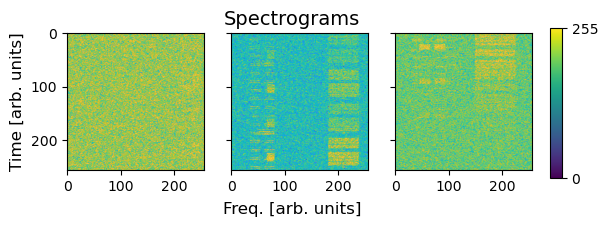

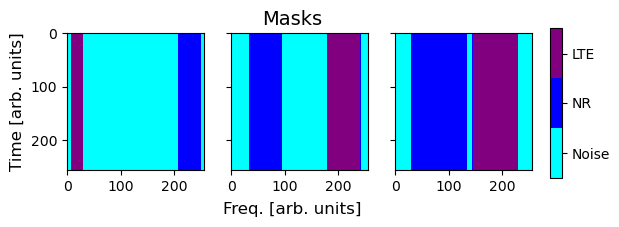

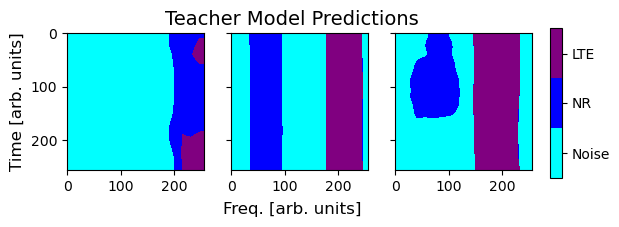

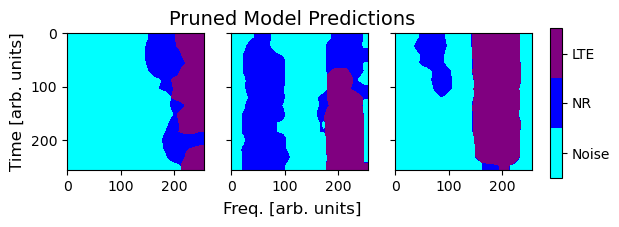

In [75]:
plot_spects(spects=[inv_transform(i.cpu()) for i in spects])
plot_masks(masks=[inv_target_transform(i) for i in masks])
plot_masks(masks=teacher_preds.cpu(), prediction=True, is_teacher=True)
plot_masks(masks=preds.cpu(), prediction=True, is_pruned=True)

**Note:** You can view different examples by rerunning the previous few code cells.

Now, let's evaluate the same metrics as we did above in the [Model Validation](#Model-Validation) section, but now for the challenge dataset. Given the model's lack of exposure to these combined frames during the training process, we anticipate the model's capabilities to be somewhat diminished. Yet, we still anticipate reasonable results.

In [57]:
print_metrics_report(dataloader=challenge_loader, model=teacher_model)

+---------+------------+----------+-------------+------------+-------+
|  Class  |  Accuracy  |  Recall  |  Precision  |  F1 Score  |  IoU  |
+=========+============+==========+=============+============+=======+
|  Noise  |    0.86    |   0.86   |    0.78     |    0.82    | 0.69  |
+---------+------------+----------+-------------+------------+-------+
|   NR    |    0.86    |   0.86   |    0.88     |    0.87    | 0.77  |
+---------+------------+----------+-------------+------------+-------+
|   LTE   |    0.73    |   0.73   |    0.88     |    0.80    | 0.67  |
+---------+------------+----------+-------------+------------+-------+
|  Mean   |    0.82    |   0.82   |    0.85     |    0.83    | 0.71  |
+---------+------------+----------+-------------+------------+-------+


In [76]:
print_metrics_report(dataloader=challenge_loader, model=model)

+---------+------------+----------+-------------+------------+-------+
|  Class  |  Accuracy  |  Recall  |  Precision  |  F1 Score  |  IoU  |
+=========+============+==========+=============+============+=======+
|  Noise  |    0.80    |   0.80   |    0.62     |    0.70    | 0.53  |
+---------+------------+----------+-------------+------------+-------+
|   NR    |    0.57    |   0.57   |    0.80     |    0.66    | 0.49  |
+---------+------------+----------+-------------+------------+-------+
|   LTE   |    0.71    |   0.71   |    0.70     |    0.70    | 0.54  |
+---------+------------+----------+-------------+------------+-------+
|  Mean   |    0.69    |   0.69   |    0.70     |    0.69    | 0.52  |
+---------+------------+----------+-------------+------------+-------+


In [57]:
def measure_inference_time(model: torch.nn.Module, validation_loader: torch.utils.data.DataLoader, num_tests: int = 5, num_iterations: int = 20) -> None:
    """
    Measure the inference time of a PyTorch model on a CPU for multiple tests and iterations.

    Args:
        model (torch.nn.Module): The PyTorch model.
        validation_loader (torch.utils.data.DataLoader): The DataLoader for the validation dataset.
        num_tests (int): The number of tests to run the inference.
        num_iterations (int): The number of iterations to run the inference for each test.

    Returns:
        None: Prints the total and average inference time for each test and overall statistics.
    """
    # Move the model to CPU and set it to evaluation mode
    device = torch.device("cpu")
    model.to(device)
    model.eval()

    # Disable gradient calculations for inference
    overall_total_time = 0.0

    with torch.no_grad():
        for test in range(num_tests):
            print(f"Running Test {test + 1}/{num_tests}")
            test_total_time = 0.0

            for iteration in range(num_iterations):
                print(f"  Iteration {iteration + 1}/{num_iterations}")
                iteration_inference_time = 0.0

                for batch in validation_loader:
                    # Move the batch to the CPU (if tensors are not already on CPU)
                    batch = [tensor.to(device) for tensor in batch]

                    # Start timing
                    start_time = time.time()

                    # Perform inference
                    inputs = batch[0]  # Assuming the first element in the batch is the input tensor
                    _ = model(inputs)

                    # End timing
                    batch_inference_time = time.time() - start_time
                    iteration_inference_time += batch_inference_time

                # Add the inference time for this iteration to the total for the test
                test_total_time += iteration_inference_time
                print(f"    Inference time for iteration {iteration + 1}: {iteration_inference_time:.4f} seconds")

            # Calculate and print the average inference time per batch for this test
            avg_test_time = test_total_time / (len(validation_loader) * num_iterations)
            overall_total_time += test_total_time

            print(f"Total inference time for Test {test + 1}: {test_total_time:.4f} seconds")
            print(f"Average inference time per batch for Test {test + 1}: {avg_test_time:.4f} seconds\n")

    # Calculate and print overall statistics
    overall_avg_time = overall_total_time / (num_tests * len(validation_loader) * num_iterations)
    print(f"Overall total inference time for {num_tests} tests: {overall_total_time:.4f} seconds")
    print(f"Overall average inference time per batch: {overall_avg_time:.4f} seconds")

# Example usage
# avg_time = measure_inference_time(model, validation_loader, num_tests=3, num_iterations=10)



In [58]:
def get_model_size(model: torch.nn.Module) -> float:
    """
    Calculate the size of a PyTorch model in megabytes (MB).

    Args:
        model (torch.nn.Module): The PyTorch model.

    Returns:
        float: The size of the model in megabytes (MB).
    """
    # Initialize total size in bytes
    total_size_in_bytes = 0

    # Iterate through all parameters and buffers to calculate size
    for param in model.parameters():
        total_size_in_bytes += param.nelement() * param.element_size()  # nelement: total number of elements in tensor

    for buffer in model.buffers():
        total_size_in_bytes += buffer.nelement() * buffer.element_size()

    # Convert bytes to megabytes (1 MB = 1024 * 1024 bytes)
    total_size_in_mb = total_size_in_bytes / (1024 ** 2)

    return total_size_in_mb


In [59]:
model_size = get_model_size(model)
print(f"Model Size: {model_size:.2f} MB")

Model Size: 0.68 MB
